<a href="https://colab.research.google.com/github/graviada/colabRepo/blob/master/2022/TorchML%20(6%2C%202022)/Lab4/PyTorch_Lab4_1_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

import torch.optim as optim

from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

from itertools import chain
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

In [ ]:
# Задаем необходимые константы
LATENT_SIZE = 10  # размерность скрытого пространства, можно варьировать.
CH_CAPACITY = 16
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 1e-3

ANIMATION_IMAGES = 5
ANIMATION_N_FRAMES = (ANIMATION_IMAGES - 1) * 20
ANIMATION_INTERVAL = 50


In [ ]:
# В этой части лабораторной работы вам предстоит реализовать и обучить автокодировочную сеть на наборе данных MNIST.
# Сценарий выполнения кода:
# 1. Обучение автокодировщика.
# 2. Отображение проекции скрытого пространства на плоскость для визуальной оценки распределения данных в скрытом пространстве.
# 3. Интерполяция между несколькими точками в скрытом пространстве, декодирование промежуточных точек в исходное пространство
# и анимация результата.
# 4. Обучение простого классификатора на исходных данных (изображениях цифр) и на векторах в скрытом пространстве.
# 5. Проверка полученных классификаторов на тестовых данных.

class Encoder(nn.Module):
    # Класс кодировщика, необходимо реализовать.

    def __init__(self, latent_size):
        super().__init__()
        # ВАШ КОД ЗДЕСЬ
        c = CH_CAPACITY
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=latent_size)
        # ============

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        # ============
        return x

In [ ]:
class Decoder(nn.Module):
    # Класс декодировщика, необходимо реализовать.

    def __init__(self, latent_size):
        super().__init__()
        # ВАШ КОД ЗДЕСЬ
        c = CH_CAPACITY
        self.fc = nn.Linear(in_features=latent_size, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
        # ============

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ

        x = self.fc(x)
        x = x.view(x.size(0), CH_CAPACITY*2, 7, 7)
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv1(x))
        # ============
        return x

In [ ]:
class SimpleClassifier(nn.Module):
    # Класс простого классификатора.

    def __init__(self, inputs, outputs):
        super().__init__()
        self.fc = nn.Linear(inputs, outputs)
        self._inputs = inputs

    def forward(self, x):
        x = x.reshape(-1, self._inputs)
        x = self.fc(x)
        return x

In [ ]:
class LatentSpaceDataset(Dataset):
    # Класс для преобразования изображений в вектора скрытого пространства.

    def __init__(self, orig_space_data_loader, encoder):
        super().__init__()
        self._data = list()
        for batch, target in orig_space_data_loader:
            latent_space_imgs = encoder(batch).detach()
            self._data.extend(zip(latent_space_imgs, target))

    def __len__(self):
        return len(self._data)

    def __getitem__(self, i):
        return self._data[i]

In [ ]:
def train_ae(data_loader, encoder, decoder, epochs, lr):
    # Функция для обучения автокодировщика.
    # Принимает на вход загрузчик тренеровочных данных,
    # кодировщик, декодировщик, количество эпох для обучения и скорость обучения.

    encoder.train()
    decoder.train()

    print('Обучение автокодировщика..')

    loss_func = nn.MSELoss() # функция потерь, нужно выбрать.
    optimizer = torch.optim.Adam(chain(encoder.parameters(), decoder.parameters()))  # оптимизатор, нужно выбрать.
    loss_history = list()
    for epoch in range(epochs):
        for i, (batch, _) in tqdm(enumerate(data_loader)):
            # ВАШ КОД ЗДЕСЬ
            optimizer.zero_grad()
            loss = loss_func(decoder(encoder(batch)), batch)
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())
            # ============
        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')

    print('Готово!')

    encoder.eval()
    decoder.eval()

    plt.plot(loss_history)
    plt.show()

In [ ]:
def train_classifier(data_loader, model, epochs, lr):
    # Функция для обучения классификатора.

    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    print('Обучение классификатора..')
    for epoch in range(epochs):
        for i, (batch, target) in enumerate(data_loader):
            optimizer.zero_grad()
            loss = loss_func(model(batch), target)
            loss.backward()
            optimizer.step()
        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')
    print('Готово!')
    model.eval()

In [ ]:
def test_classifier(data_loader, classifier):
    # Функция для тестирования классификатора.
    batch, target = next(iter(data_loader))
    print(accuracy_score(torch.argmax(classifier(batch), dim=1).detach().numpy(), target))

def lerp(v1, v2, t):
    # Функция для линейной интерполяции между двумя векторами.
    return v1 * (1 - t) + v2 * t

def get_frame(i, data):
    # Функция для анимации
    i = min(i, len(data) - 1)
    ax.clear()
    ax.imshow(data[i])

In [ ]:
# Подгружаем данные и узнаем их размер
img_transform = Compose([
    ToTensor(),
    Normalize((0.5,), (0.5,))
])

train_data = MNIST('data', train=True, download=True, transform=img_transform)
test_data = MNIST('data', train=False, download=True, transform=img_transform)
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

for i, (images, labels) in enumerate(train_data_loader):
    print(images.size())
    break

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

torch.Size([128, 1, 28, 28])


In [ ]:
encoder = Encoder(LATENT_SIZE)
decoder = Decoder(LATENT_SIZE)

print('Архитектура кодировщика: ')
summary(encoder, (1, 28, 28))
print()
print('Архитектура декодировщика: ')
summary(decoder, [[LATENT_SIZE]])

Архитектура кодировщика: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             272
            Conv2d-2             [-1, 32, 7, 7]           8,224
            Linear-3                   [-1, 10]          15,690
Total params: 24,186
Trainable params: 24,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.09
Estimated Total Size (MB): 0.13
----------------------------------------------------------------

Архитектура декодировщика: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1568]          17,248
   ConvTranspose2d-2           [-1, 16, 14, 14]           8,208
   ConvTranspose2d-3            [-1, 1, 28, 28]     

Обучение автокодировщика..


469it [00:36, 12.84it/s]


Эпоха 1 / 10. Потери на последнем пакете: 0.09622957557439804


469it [00:35, 13.13it/s]


Эпоха 2 / 10. Потери на последнем пакете: 0.08644845336675644


469it [00:35, 13.06it/s]


Эпоха 3 / 10. Потери на последнем пакете: 0.07733564078807831


469it [00:35, 13.23it/s]


Эпоха 4 / 10. Потери на последнем пакете: 0.06867343932390213


469it [00:35, 13.07it/s]


Эпоха 5 / 10. Потери на последнем пакете: 0.07399781048297882


469it [00:36, 12.81it/s]


Эпоха 6 / 10. Потери на последнем пакете: 0.0661529079079628


469it [00:35, 13.26it/s]


Эпоха 7 / 10. Потери на последнем пакете: 0.06595674157142639


469it [00:35, 13.26it/s]


Эпоха 8 / 10. Потери на последнем пакете: 0.06170469522476196


469it [00:35, 13.26it/s]


Эпоха 9 / 10. Потери на последнем пакете: 0.06189252808690071


469it [00:35, 13.21it/s]


Эпоха 10 / 10. Потери на последнем пакете: 0.059564851224422455
Готово!


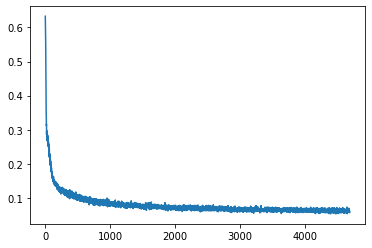

In [ ]:
train_ae(train_data_loader, encoder, decoder, EPOCHS, LEARNING_RATE)

test_imgs = list()
for batch, target in train_data_loader:
    test_imgs.extend(zip(batch, target))
    if len(test_imgs) > 5000:
        break
imgs_list, targets = zip(*test_imgs)
imgs = torch.stack(imgs_list)

Проецирование скрытого пространства на плоскость..


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Готово!


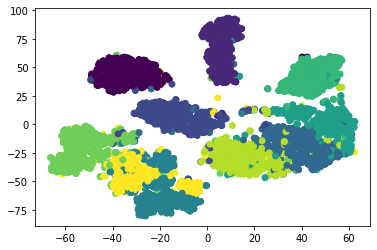

In [ ]:
print('Проецирование скрытого пространства на плоскость..')
tsne = TSNE()
latent_imgs_emb = [encoder(img.unsqueeze(0))[0].detach().numpy() for img in imgs]
latent_imgs_emb = tsne.fit_transform(np.array(latent_imgs_emb))
x, y = zip(*latent_imgs_emb)
plt.scatter(x, y, c=targets)
print('Готово!')
plt.show()

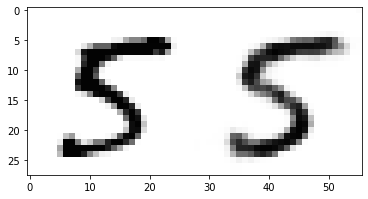

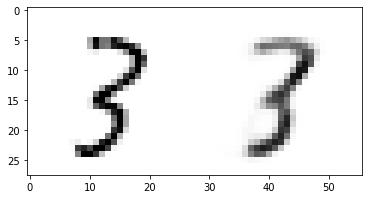

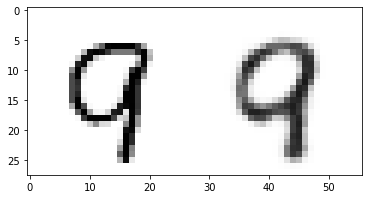

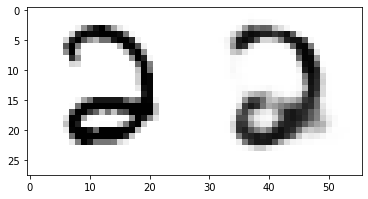

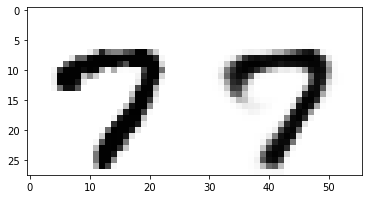

In [ ]:
latent_imgs = encoder(imgs)
restored_imgs = decoder(latent_imgs)

for i in range(5):
    orig_restored = torch.hstack((imgs[i][0], restored_imgs[i][0].detach()))
    plt.imshow(orig_restored.numpy(), cmap='Greys')
    plt.show()

Расчет анимации..


RuntimeError: ignored

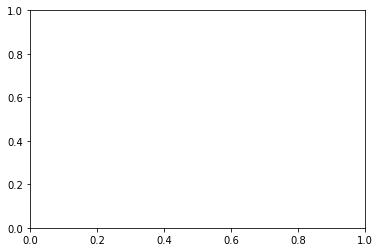

In [ ]:
print('Расчет анимации..')
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
animation_data = list()
for i in range(4 * 20):
    frames_per_conn = ANIMATION_N_FRAMES // (ANIMATION_IMAGES - 1)
    vec_index = i // frames_per_conn
    t = i % frames_per_conn / frames_per_conn
    interp_vec = lerp(latent_imgs[vec_index], latent_imgs[vec_index + 1], t)
    print(interp_vec)
    restored_img = decoder(interp_vec)
    # restored_img = restored_img.reshape(1568)
    animation_data.append(restored_img[0][0].detach().numpy())
print('Готово!')

In [ ]:
animation = FuncAnimation(figure, get_frame, frames=ANIMATION_N_FRAMES, interval=ANIMATION_INTERVAL, fargs=(animation_data,))
plt.show()

x_classifier = SimpleClassifier(28 * 28, 10)
train_classifier(train_data_loader, x_classifier, epochs=10, lr=1e-4)

latent_space_train_data_loader = DataLoader(LatentSpaceDataset(train_data_loader, encoder), batch_size=BATCH_SIZE, shuffle=True)

z_classifier = SimpleClassifier(LATENT_SIZE, 10)
train_classifier(latent_space_train_data_loader, z_classifier, epochs=10, lr=1e-4)

orig_test_data_loader = DataLoader(test_data, batch_size=256, shuffle=True)
latent_test_data_loader = DataLoader(LatentSpaceDataset(orig_test_data_loader, encoder), batch_size=256, shuffle=True)

test_classifier(orig_test_data_loader, x_classifier)
test_classifier(latent_test_data_loader, z_classifier)

Обучение классификатора..
Эпоха 1 / 10. Потери на последнем пакете: 0.7653692364692688
Эпоха 2 / 10. Потери на последнем пакете: 0.5969418883323669
Эпоха 3 / 10. Потери на последнем пакете: 0.5167430639266968
Эпоха 4 / 10. Потери на последнем пакете: 0.35575053095817566
Эпоха 5 / 10. Потери на последнем пакете: 0.3645225465297699
Эпоха 6 / 10. Потери на последнем пакете: 0.3448893129825592
Эпоха 7 / 10. Потери на последнем пакете: 0.4227226972579956
Эпоха 8 / 10. Потери на последнем пакете: 0.3198491930961609
Эпоха 9 / 10. Потери на последнем пакете: 0.36204007267951965
Эпоха 10 / 10. Потери на последнем пакете: 0.2259996384382248
Готово!
Обучение классификатора..
Эпоха 1 / 10. Потери на последнем пакете: 2.367619276046753
Эпоха 2 / 10. Потери на последнем пакете: 1.9181452989578247
Эпоха 3 / 10. Потери на последнем пакете: 1.5876646041870117
Эпоха 4 / 10. Потери на последнем пакете: 1.1258013248443604
Эпоха 5 / 10. Потери на последнем пакете: 0.9400942921638489
Эпоха 6 / 10. Потери на